## Imports

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict
from functools import partial
from itertools import count
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk import pos_tag
import string
import re
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.svm import LinearSVC,SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB,MultinomialNB
%matplotlib inline

## Train Folders

In [2]:
descriptionTrainFolder = "/Users/francescoperera/Desktop/data/descriptions_train"
featuresTrainFolder = "/Users/francescoperera/Desktop/data/features_train"
imagesTrainFolder = "/Users/francescoperera/Desktop/data/images_train"
tagsTrainFolder = "/Users/francescoperera/Desktop/data/tags_train"

## Test Folders

In [3]:
descriptionTestFolder = "/Users/francescoperera/Desktop/data/descriptions_test"
featuresTestFolder = "/Users/francescoperera/Desktop/data/features_test"
imagesTestFolder = "/Users/francescoperera/Desktop/data/images_test"
tagsTestFolder = "/Users/francescoperera/Desktop/data/tags_test"

## Number of files

In [4]:
numTrain = 10000
numTest = 2000

## Read Files

In [5]:
def readTagsFile(fileName):
    tags = []
    f = open(fileName,"r")
    for line in f:
        line = line.split(":") # possibly also consider using the keys in each line(vehicle,outdoor etc..)
        tag = line[-1].replace("\n","")
        tags.append(tag)
    return tags

def readDescriptionFile(fileName):
    desc = []
    f = open(fileName,"r")
    for line in f:
        noPuncSentence = stripPunctuation(line)
        desc.append(noPuncSentence)
    return desc

def stripPunctuation(s):
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    return regex.sub(' ', s)

## Tags Analysis

In [6]:
def getTagDict(num,tagFolder):
    tags = {}
    for n in range(num):
        f = tagFolder +"/" + str(n) + ".txt"
        fileTags = readTagsFile(f)
        #newTags = stemTags(fileTags)
        for tag in fileTags:
            if str(tag) not in tags.keys():
                tags[str(tag)] = 0
            else:
                tags[str(tag)] +=1
    return tags

In [7]:
tagDict = getTagDict(numTrain,tagsTrainFolder)

In [8]:
print tagDict

{'toilet': 287, 'fire hydrant': 151, 'sports ball': 339, 'bicycle': 284, 'kite': 200, 'laptop': 303, 'potted plant': 356, 'tennis racket': 293, 'teddy bear': 183, 'donut': 117, 'snowboard': 128, 'carrot': 138, 'motorcycle': 327, 'oven': 246, 'keyboard': 169, 'scissors': 72, 'chair': 1029, 'couch': 344, 'mouse': 158, 'airplane': 221, 'boat': 276, 'apple': 106, 'sheep': 122, 'horse': 218, 'sandwich': 207, 'banana': 169, 'cup': 746, 'tv': 351, 'backpack': 428, 'toaster': 23, 'bowl': 592, 'microwave': 112, 'bench': 475, 'book': 446, 'elephant': 178, 'orange': 130, 'tie': 305, 'stop sign': 141, 'knife': 331, 'pizza': 265, 'fork': 267, 'hair drier': 11, 'frisbee': 194, 'umbrella': 357, 'parking meter': 57, 'bus': 330, 'suitcase': 188, 'bear': 86, 'vase': 310, 'toothbrush': 79, 'spoon': 292, 'train': 330, 'sink': 389, 'wine glass': 214, 'handbag': 597, 'cell phone': 436, 'bird': 305, 'broccoli': 162, 'refrigerator': 204, 'remote': 239, 'surfboard': 321, 'cow': 177, 'dining table': 959, 'hot d

In [9]:
print list(tagDict.keys())

['toilet', 'fire hydrant', 'sports ball', 'bicycle', 'kite', 'laptop', 'potted plant', 'tennis racket', 'teddy bear', 'donut', 'snowboard', 'carrot', 'motorcycle', 'oven', 'keyboard', 'scissors', 'chair', 'couch', 'mouse', 'airplane', 'boat', 'apple', 'sheep', 'horse', 'sandwich', 'banana', 'cup', 'tv', 'backpack', 'toaster', 'bowl', 'microwave', 'bench', 'book', 'elephant', 'orange', 'tie', 'stop sign', 'knife', 'pizza', 'fork', 'hair drier', 'frisbee', 'umbrella', 'parking meter', 'bus', 'suitcase', 'bear', 'vase', 'toothbrush', 'spoon', 'train', 'sink', 'wine glass', 'handbag', 'cell phone', 'bird', 'broccoli', 'refrigerator', 'remote', 'surfboard', 'cow', 'dining table', 'hot dog', 'car', 'clock', 'skateboard', 'dog', 'bed', 'cat', 'person', 'skis', 'giraffe', 'truck', 'bottle', 'baseball bat', 'cake', 'baseball glove', 'traffic light', 'zebra']


In [10]:
print list(tagDict.values())

[287, 151, 339, 284, 200, 303, 356, 293, 183, 117, 128, 138, 327, 246, 169, 72, 1029, 344, 158, 221, 276, 106, 122, 218, 207, 169, 746, 351, 428, 23, 592, 112, 475, 446, 178, 130, 305, 141, 331, 265, 267, 11, 194, 357, 57, 330, 188, 86, 310, 79, 292, 330, 389, 214, 597, 436, 305, 162, 204, 239, 321, 177, 959, 121, 1021, 441, 256, 391, 314, 354, 5322, 237, 217, 498, 707, 193, 216, 198, 327, 168]


In [11]:
def plotTagFrequency(d):
    plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.bar(range(len(d)), list(d.values()), align='center')
    plt.xticks(range(len(d)), list(d.keys()), rotation=90)

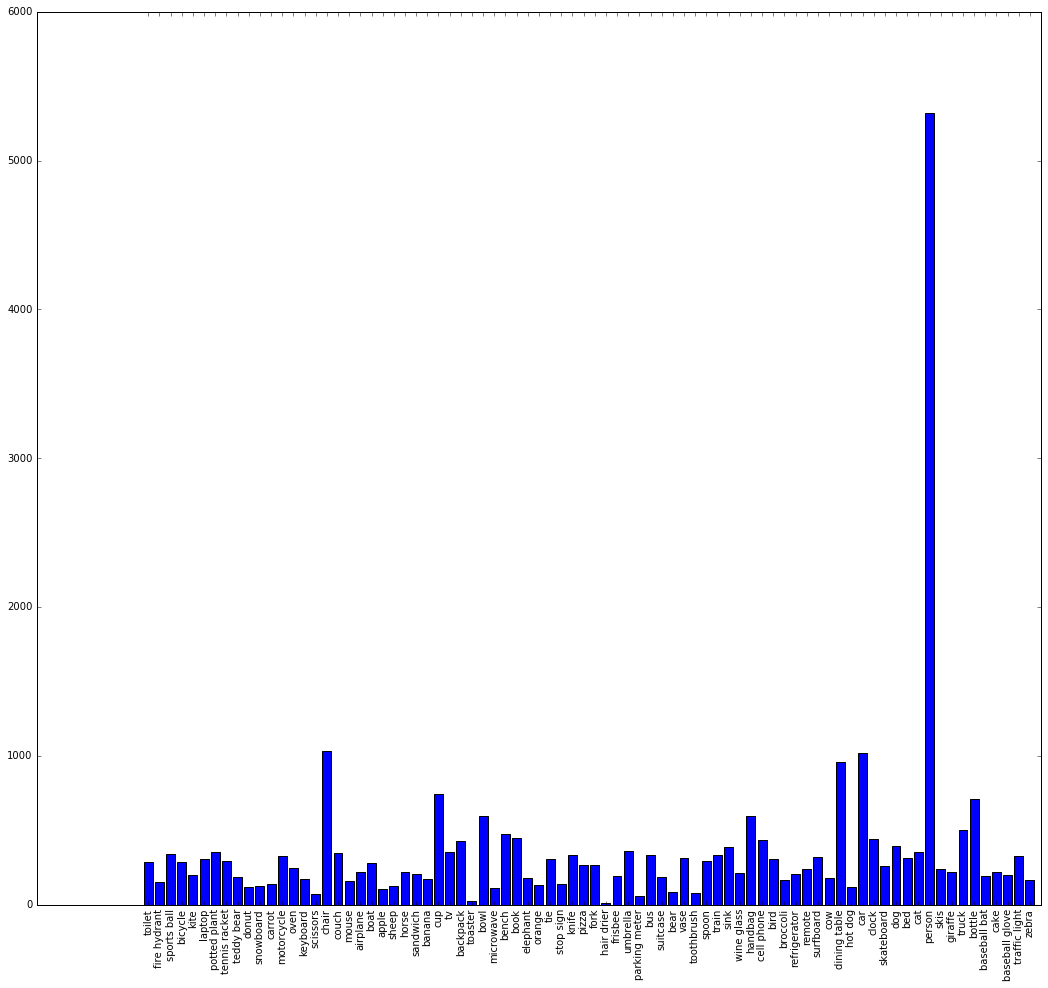

In [12]:
plotTagFrequency(tagDict)

The least frequent tags are easier to use in classification, whereas more frequent tags are harder to use to point to a specific image. This could help us understand which tags are more important than others when trying to determine the best tag out of a tie.

In [13]:
def plotTagNormalizeFrequency(d):
    newValues = [freq/float(sum(d.values())) for freq in list(d.values())]
    plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.bar(range(len(d)), newValues, align='center')
    plt.xticks(range(len(d)), list(d.keys()), rotation=90)

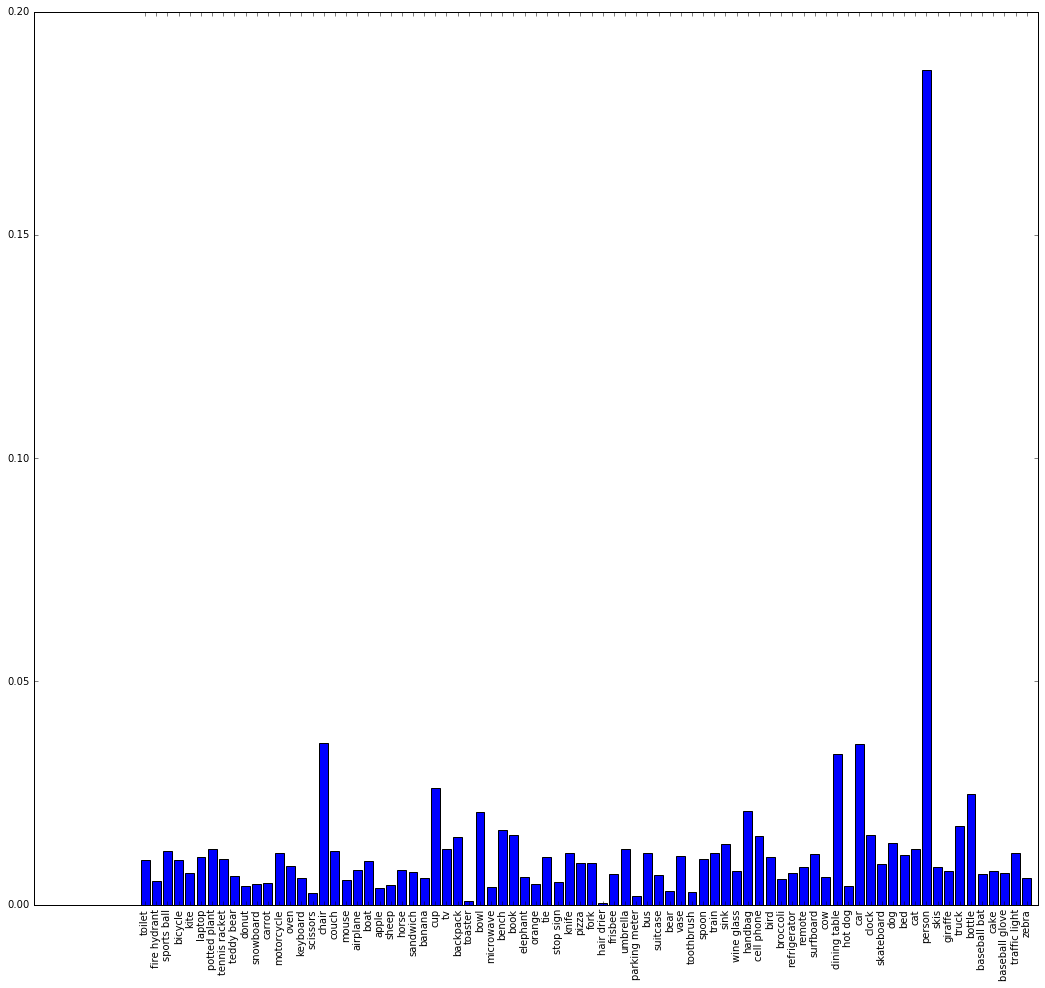

In [14]:
plotTagNormalizeFrequency(tagDict)

In [15]:
print tagDict['chair']/float(sum(tagDict.values()))

0.036167445784


## Generate Tag Vector

In [16]:
def createBag(num,tagFolder):
    tags = {}
    for n in range(num):
        f = tagFolder +"/" + str(n) + ".txt"
        fileTags = readTagsFile(f)
        #newTags = stemTags(fileTags) - maybe add stemming - Francesco
        for t in fileTags:
            if t not in tags.keys():
                tags[t] = 0
    return tags

def stemTags(lst):
    newTags = []
    for word in lst:
        stem = str(PorterStemmer().stem(word))
        newTags.append(stem)
    return newTags

def indexBag(bag):
    idx = 0
    for tag in bag.keys():
        bag[tag] = idx
        idx+=1
    return bag

def getTagVectors(num,tagFolder,indexedTagBag):
    tagVecs = np.zeros((num,len(indexedTagBag.keys()))) #2D Array of size (file number, len(indexedBagTag.keys))
    for n in range(num):
        f = tagFolder +"/" + str(n) + ".txt"
        fileTags = readTagsFile(f)
        #newTags = stemTags(fileTags) - maybe add stemming - Francesco
        for tag in fileTags:
            if tag in indexedTagBag.keys():
                tagVecs[n,indexedTagBag[tag]] = 1
            else:
                print str(tag) + " is not in the tag BOW"
    return pd.DataFrame(tagVecs,columns = indexedTagBag.keys())

In [17]:
tagBag = createBag(numTrain,tagsTrainFolder)
indexedTagBag = indexBag(tagBag)

In [18]:
tagVectors = getTagVectors(numTrain,tagsTrainFolder,indexedTagBag)
print tagVectors.shape

(10000, 80)




## Description Processing

In [19]:
def getStopWords():
    return set(stopwords.words("english"))

def lowerCase(x):
    return x.lower()

def lemmatize(lmt,x):
    return lmt.lemmatize(x)

def getPos(line):
    return pos_tag(line)

def tokenize(line):
    return line.split()

def stripPunctuation(s):
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    return regex.sub(' ', s)

def stemmer(line):
    stemmer = PorterStemmer()
    stemmedLine = []
    for word in line:
        #if pos == "NN": #only stem nouns
        stem = stemmer.stem(word)
        stemmedLine.append(stem)
    return stemmedLine 

def stemmedDescriptions(lst):
    stemmedDescriptions = []
    for line in lst:
        tokenizedLine = tokenize(line)
        stemmedDescriptions.append(stemmer(tokenizedLine))
    return stemmedDescriptions


In [20]:
def createBag(num,descFolder):
    bag = {}
    stopWords = getStopWords()
    for n in range(num):
        f = descFolder +"/" + str(n) + ".txt"
        fileDescriptions = readDescriptionFile(f) #2D Array
        stemDescriptions = stemmedDescriptions(fileDescriptions) #applying stemming so to aggregate similar words
        for desc in stemDescriptions:
            for word in desc:
                lowerWord = lowerCase(word)
                if str(lowerWord) not in bag.keys() and str(lowerWord) != "" and str(lowerWord) not in stopWords:
                    bag[str(lowerWord)] = 0 
    return bag

def indexBag(bag):
    idx = 0
    for tag in bag.keys():
        bag[tag] = idx
        idx+=1
    return bag

def binaryVectorizeDescriptions(num,descFolder,indexedDescBag):
    stopWords = getStopWords()
    featureVectorList = []
    for n in range(num):
        imageTagVec = [0.0 for tag in range(len(indexedDescBag.keys()))]
        f = descFolder +"/" + str(n) + ".txt"
        fileDescriptions = readDescriptionFile(f) #2D Array
        stemDescriptions = stemmedDescriptions(fileDescriptions) #applying stemming so to aggregate similar words
        for desc in stemDescriptions:
            for word in desc:
                lowerWord = lowerCase(word)
                if str(lowerWord) in indexedDescBag.keys() and str(lowerWord) != "" and str(lowerWord) not in stopWords:
                    imageTagVec[indexedDescBag[str(lowerWord)]] +=1.0
        featureVectorList.append(imageTagVec)
    return pd.DataFrame(featureVectorList,columns = indexedDescBag.keys())

def tfIdfVectorizeDecriptions(num,descFolder):
    """
    this technique will be very sparse - consider using dimensionality reduction here
    """
    tf = TfidfVectorizer(analyzer='word', 
                         ngram_range=(1,1), 
                         min_df = 1,
                         stop_words = 'english',
                         lowercase = True) #add norm="l1" or "l2" to normalize vectors
    descCorpus = []
    for n in range(num):
        f = descFolder +"/" + str(n) + ".txt"
        fileDescriptions = readDescriptionFile(f) #2D Array
        stemDescriptions = stemmedDescriptions(fileDescriptions) #applying stemming so to aggregate similar words
        for desc in stemDescriptions:
            descCorpus.append(" ".join(desc))
    return tf,tf.fit_transform(descCorpus) #TfIdfVectorizer uses unicode strings for column names.
    #return tf

In [21]:
descBag = createBag(numTrain,descriptionTrainFolder)
indexedDescBag = indexBag(descBag)

In [22]:
descVectors = binaryVectorizeDescriptions(numTrain,descriptionTrainFolder,indexedDescBag) #binary feature representation

In [23]:
print descVectors.shape

(10000, 6456)


In [24]:
normalizedDescVector = descVectors.div(descVectors.sum(axis=1), axis=0)

In [25]:
print normalizedDescVector.iloc[0]['tabl']

0.161290322581


In [25]:
#tfIDFObj,descTFIDF = tfIdfVectorizeDecriptions(numTrain,descriptionTrainFolder)

In [26]:
#print tfIDFObj.get_feature_names()

[u'00', u'05', u'10', u'103', u'106', u'11', u'12', u'12th', u'13th', u'142053', u'15', u'1802', u'1830', u'1917', u'1929', u'1932', u'1950', u'1960', u'1969', u'19th', u'1st', u'20', u'2013', u'23', u'238', u'25', u'29', u'2am', u'2x4', u'30', u'30th', u'31', u'32', u'35', u'360', u'38', u'39', u'3d', u'3rd', u'40', u'43', u'44', u'48', u'480', u'4pm', u'50', u'51', u'53', u'535', u'55', u'551', u'5th', u'600', u'6am', u'6pm', u'6th', u'747', u'75', u'750', u'7th', u'80', u'800', u'811', u'84', u'89', u'95th', u'aa', u'abandon', u'abdomen', u'abil', u'abl', u'abll', u'abnorm', u'aboard', u'abook', u'abou', u'abov', u'abraham', u'abreast', u'abstract', u'abund', u'abyss', u'acacia', u'academ', u'acceler', u'accent', u'accept', u'access', u'accessori', u'accid', u'accompani', u'account', u'accumul', u'ace', u'achiev', u'acket', u'acknowledg', u'aclock', u'acm', u'acorn', u'acrobat', u'act', u'action', u'activ', u'actor', u'actual', u'ad', u'add', u'addit', u'address', u'adjac', u'adjoin

In [27]:
#print descTFIDF.toarray().shape #toarray() converts this to a np array

(50194, 6344)


In [26]:
print "start"

start


In [28]:
# descTFIDFArray = descTFIDF.toarray()
# zeroColsIdx = np.where(~descTFIDFArray.any(axis=1))[0] #list of columns indices in descTFIDFArray that include all 0s.

In [58]:
def reduceDimensions(x,ncomp):
    #ncomp = number of components
    pca = PCA(ncomp)
    pca.fit(x)
    newX = pca.transform(x)
    return newX

In [ ]:
descPCAArray= reduceDimensions(descTFIDFArray,500) #PCA rray

In [ ]:
print descPCAArray.shape,descTFIDFArray.shape

## Classifiers

In [60]:
def SVM(train,trainLabel,test):
#     clf = SVC()
#     clf.fit(train,trainLabel)
#     preds = clf.predict(test)
    preds = OneVsRestClassifier(LinearSVC(random_state=0)).fit(train, trainLabel).predict(test)
    return preds

In [110]:
def logRegression(train,trainLabel,test,cVal=None):
    preds = OneVsRestClassifier(LogisticRegression(C=cVal,penalty="l1")).fit(train, trainLabel).predict(test)
    return preds

In [97]:
def randomForest(train,trainLabel,test):
    preds = OneVsRestClassifier(RandomForestClassifier()).fit(train, trainLabel).predict(test)
    return preds

In [107]:
def naiveBayes(train,trainLabel,test):
    preds = OneVsRestClassifier(BernoulliNB()).fit(train, trainLabel).predict(test)
    return preds

In [35]:
print descVectors.shape

(10000, 6456)


In [36]:
print tagVectors.values[:3,10:12]

[[ 0.  0.]
 [ 0.  1.]
 [ 0.  0.]]


In [37]:
print tagVectors.values

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


## Use kNN to find the 20 closest tag vectors for each test prediction vector

In [85]:
def kNN(tags,k,preds):
    model = NearestNeighbors(n_neighbors= k , algorithm='kd_tree').fit(tags)
    dist,idxs = model.kneighbors(preds)
    return dist,idxs

def MAP(i):
    score = (21 - i)/float(20)
    return score

In [103]:
def crossValidate(data,labels,classifier):
    """
    data = training data
    labels = training data labels
    algo = algorithmn that creates predictions
    """
    totalAvgMap = []
    totalAvgAcc = []
    kf = KFold(len(data),3)
    for trainIdx,testIdx in kf:
        mapScores=[]
        c = 0
        train = np.array([data[idx] for idx in trainIdx])
        test = np.array([data[idx] for idx in testIdx])
        trainLabels = np.array([labels[idx] for idx in trainIdx])
        testLabels = np.array([labels[idx] for idx in testIdx])
        testPreds = classifier(train,trainLabels,test)
        for i in range(len(testPreds)):
            if np.array_equal(testPreds[i],testLabels[i]):
                c+=1
        dist,kNNPreds = kNN(testLabels,20,testPreds)
        for i in range(len(kNNPreds)):
            if i in kNNPreds[i]:
                rankI = list(kNNPreds[i]).index(i)
                mapScores.append(MAP(rankI))
            else:
                mapScores.append(0)
        avgMAP = sum(mapScores)/float(len(mapScores))
        print "avgMAP: " + str(avgMAP)
        print "Accuracy: " + str(c/float(len(testPreds))) + " ,(" + str(c) + "/" + str(len(testPreds)) + ")"
        totalAvgMap.append(avgMAP)
        totalAvgAcc.append(c/float(len(testPreds)))
    print "Average MAP: " +str(np.array(totalAvgMap).mean())
    print "Average Accuracy: " + str(np.array(totalAvgAcc).mean())

In [108]:
print descVectors.values.shape,tagVectors.values.shape
crossValidate(descVectors.values,tagVectors.values,naiveBayes)

(10000, 6456) (10000, 80)
avgMAP: 0.0640521895621
Accuracy: 0.0941811637672 ,(314/3334)
avgMAP: 0.0627512751275
Accuracy: 0.0954095409541 ,(318/3333)
avgMAP: 0.05799579958
Accuracy: 0.0828082808281 ,(276/3333)
Average MAP: <built-in method mean of numpy.ndarray object at 0x10a790da0>
Average Accuracy: <built-in method mean of numpy.ndarray object at 0x10a790da0>


In [109]:
crossValidate(normalizedDescVector.values,tagVectors.values,naiveBayes)

avgMAP: 0.0640521895621
Accuracy: 0.0941811637672 ,(314/3334)
avgMAP: 0.0627512751275
Accuracy: 0.0954095409541 ,(318/3333)
avgMAP: 0.05799579958
Accuracy: 0.0828082808281 ,(276/3333)
Average MAP: <built-in method mean of numpy.ndarray object at 0x10b92ac60>
Average Accuracy: <built-in method mean of numpy.ndarray object at 0x10b92ac60>


In [113]:
def fineTuneLogRegression(C):
    bestC = 0
    bestAcc = 0
    for cVal in C:
        totalAvgMap = []
        totalAvgAcc = []
        kf = KFold(len(data),3)
        for trainIdx,testIdx in kf:
            mapScores=[]
            c = 0
            train = np.array([data[idx] for idx in trainIdx])
            test = np.array([data[idx] for idx in testIdx])
            trainLabels = np.array([labels[idx] for idx in trainIdx])
            testLabels = np.array([labels[idx] for idx in testIdx])
            testPreds = LogRegression(train,trainLabels,test)
            for i in range(len(testPreds)):
                if np.array_equal(testPreds[i],testLabels[i]):
                    c+=1
            dist,kNNPreds = kNN(testLabels,20,testPreds)
            for i in range(len(kNNPreds)):
                if i in kNNPreds[i]:
                    rankI = list(kNNPreds[i]).index(i)
                    mapScores.append(MAP(rankI))
                else:
                    mapScores.append(0)
            avgMAP = sum(mapScores)/float(len(mapScores))
            acc = c/float(len(testPreds))
            print "avgMAP: " + str(avgMAP)
            print "Accuracy: " + str(acc) + " ,(" + str(c) + "/" + str(len(testPreds)) + ")"
            totalAvgMap.append(avgMAP)
            totalAvgAcc.append(acc)
            
            if acc > bestAcc:
                bestAcc = acc
                bestC = cVal
        print "Average MAP: " +str(np.array(totalAvgMap).mean())
        print "Average Accuracy: " + str(np.array(totalAvgAcc).mean())
    print "The best C value was " + str(bestC) + "with an accuracy of " + str(bestAcc)
    return bestC

In [ ]:
bestC = fineTuneLogRegression(["0"])

## Generate  Test Description Vectors

In [ ]:
testDescVectors = binaryVectorizeDescriptions(numTest,descriptionTestFolder,indexedDescBag)

In [ ]:
normalizedTestDescVector = testDescVectors.div(testDescVectors.sum(axis=1), axis=0) 

## Run classifiers on test data

In [ ]:
print normalizedDescVector.shape,tagVectors.shape,normalizedTestDescVector.shape

In [ ]:
testPreds = randomForest(descVectors.values,tagVectors.values,testDescVectors.values)

In [ ]:
print testPreds.shape

In [ ]:
print testPreds[:50]

## Generate Test Tag Vectors¶

In [ ]:
testTagVectors = getTagVectors(numTest,tagsTestFolder,indexedTagBag)

## Run kNN on test data

In [ ]:
dist,preds = kNN(testTagVectors,20,testPreds)

In [75]:
print preds

[[  36  292 1743 ...,  760  250  594]
 [1156 1341 1529 ...,  589  607 1208]
 [1208 1033 1437 ...,   10   67   85]
 ..., 
 [1218 1660 1535 ...,   71   75   36]
 [1535 1429 1660 ...,    7   55   28]
 [1208 1033 1437 ...,   10   67   85]]


In [76]:
preds[:5]

array([[  36,  292, 1743,  359, 1131, 1231,  942,  152,   95,  255,  949,
          50,  388,  484,  141,  897,  311,  760,  250,  594],
       [1156, 1341, 1529,  763,  435,  784, 1027, 1030,  452,  753,  809,
         833,  948, 1059,  758, 1033,  542,  589,  607, 1208],
       [1208, 1033, 1437, 1421, 1030, 1340, 1648, 1574,  763, 1027,  452,
         860, 1059,  607,  784, 1475,   90,   10,   67,   85],
       [1218, 1660, 1535,  897, 1429,  152, 1135,  141,   16,   63,    2,
          57,   33,    7,   55,   12,   28,   71,   75,   36],
       [1218, 1660, 1535,  897, 1429,  152, 1135,  141,   16,   63,    2,
          57,   33,    7,   55,   12,   28,   71,   75,   36]])

## Save Results

In [ ]:
def saveResults(res,name):
    f = open(name,'w')
    f.write('Descritpion_ID,Top_20_Image_IDs\n')
    for i in xrange(2000):
        f.write(str(i)+'.txt,')
        for j in xrange(20):
            if j == 19:
                f.write(str(res[i,j])+'.jpg\n')
            else:
                f.write(str(res[i,j])+'.jpg ')
    f.close()

In [77]:
saveResults(preds,"randomForest+kNN.csv")

In [101]:
"""

Rankings:
1) Logistic Regression (on non normalized description vectors)
2) SVM(linear) (on normalized description vectors)
3) Random Forest
4) Naive Bayes
5)

"""

'\nRankings:\n'